### Graph ML for Chemical Compound Analysis: MUTAG Case Study

Author: Ludek Cizinsky (`ludek.cizinsky@epfl.ch`)

### Notebeook setup

#### Jupyter notebook utils

In [1]:
%load_ext autoreload
%autoreload 2

#### Experiment logging (optional)

In [2]:
LOGEXP = False # This enables w&b logging
if LOGEXP:
    import os
    os.environ["WANDB_NOTEBOOK_NAME"] = "run.ipynb"

#### Dependencies import

In [3]:
# Hugging face util to download dataset
from datasets import load_dataset

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Built-in
import random
from random import randint

# PyTorch
import torch
from torch import nn
# - Dataloader
from torch.utils.data import Dataset, DataLoader
# - Optimization
from torch.optim import Adam, SGD
# - Loss
from torch.nn import BCELoss, BCEWithLogitsLoss

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("RdBu")

# Networkx
import networkx as nx

# Custom scripts
from scripts.dataset import GraphDataset
from scripts.layers import (
    # Normal
    GraphConv,
    # Graph Sage
    GraphSAGEConv,
    SumAggregation,
    SqrtDegAggregation,
    MaxPoolAggregation,
    # Graph Attention
    GraphAttentionConv,
    # Pooling
    MeanPool,
    MaxPool,
)

from scripts.architecture import (
    GNN
)

from scripts.utils import (
    train_and_evaluate,
    evaluate,
    plot_graph,
    get_feat_colors,
    plot_losses_and_f1s,
)

/Users/ludekcizinsky/miniconda3/envs/cs502/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the dataset

#### Download the dataset from Hugging Face (HF)

In [4]:
dataset_hf = load_dataset("graphs-datasets/MUTAG")['train']

#### Train, validation and test split

In [5]:
# Parse the dataset into X and y
X, y = [], []
for s in dataset_hf:
    X.append(s)
    y.extend(s['y'])

# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Split the train dataset into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=42)


# Show the sizes of the datasets
n_train, n_val, n_test = len(X_train), len(X_val), len(X_test)
total = n_train + n_val + n_test
print(f"Train: {n_train/total:.2f}")
print(f"Val: {n_val/total:.2f}")
print(f"Test: {n_test/total:.2f}")

Train: 0.70
Val: 0.15
Test: 0.15


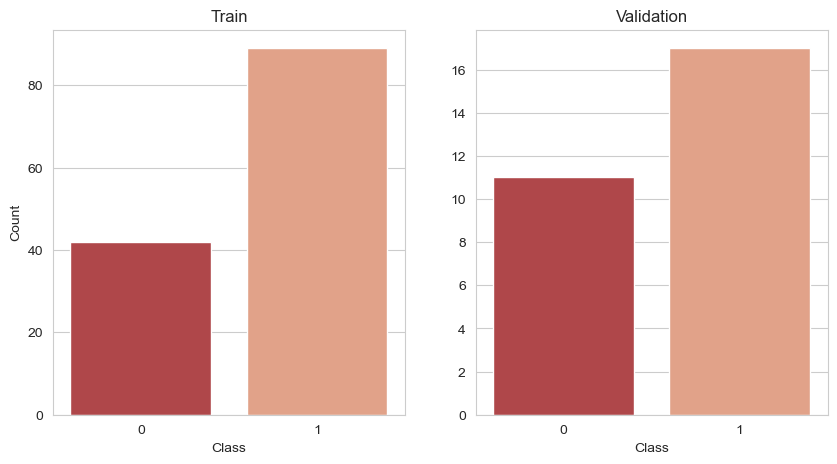

In [6]:
# Print class distribution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
# Training
sns.barplot(x=[0, 1], y=[y_train.count(0), y_train.count(1)], ax=axs[0]);
sns.barplot(x=[0, 1], y=[y_val.count(0), y_val.count(1)], ax=axs[1]);

# Add labels
axs[0].set_title("Train")
axs[1].set_title("Validation")
axs[0].set_ylabel("Count")
axs[0].set_xlabel("Class")
axs[1].set_xlabel("Class");

#### Load data using custom dataloader

In [7]:
# Define hyperparameters for the dataloader
batch_size = 64
shuffle = False

# Define custom stacking behavior for the dataloader
def collate_fn(batch):
    inputs, labels = [], []
    
    for item in batch:
        input_dict, label = item
        inputs.append(input_dict)
        labels.append(label)
    
    # Convert the list of labels to a 1D tensor
    labels = torch.tensor(labels).view(-1).type(torch.FloatTensor)
    
    return inputs, labels

# Define custom datasets
train_dataset = GraphDataset(X_train, y_train)
val_dataset = GraphDataset(X_val, y_val)
test_dataset = GraphDataset(X_test, y_test)

# Define custom dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size, 
    shuffle=shuffle,
    collate_fn=collate_fn,
    worker_init_fn=lambda _: torch.manual_seed(42)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size, 
    shuffle=shuffle,
    collate_fn=collate_fn,
    worker_init_fn=lambda _: torch.manual_seed(42)
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=shuffle,
    collate_fn=collate_fn,
    worker_init_fn=lambda _: torch.manual_seed(42)
)

### Visualize the examples of sage and mutagenic molecules

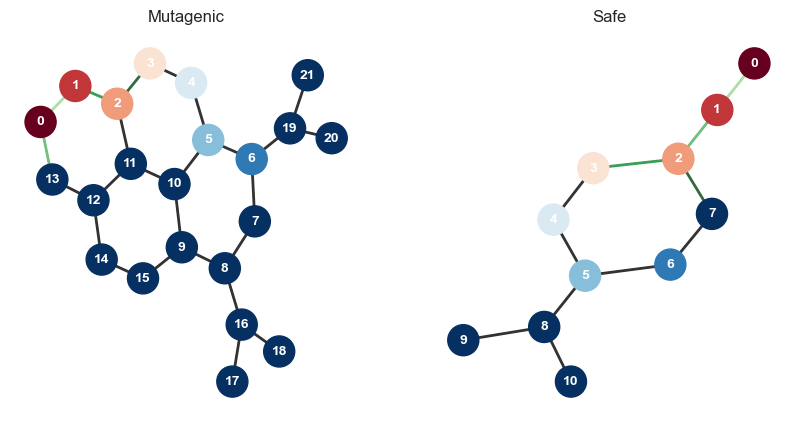

In [8]:
# From training data, get graphs with positive and negative labels
pos_graphs = [g for g in X_train if g['y'][0] == 1]
neg_graphs = [g for g in X_train if g['y'][0] == 0]

# Randomly select 1 graph from each class
pos_i, neg_i = randint(0, len(pos_graphs)-1), randint(0, len(neg_graphs)-1)
pos_graph = pos_graphs[pos_i]
neg_graph = neg_graphs[neg_i]

# Get the edges of the graphs and turn them into tensor
pos_graph_edges = torch.tensor(pos_graph['edge_index']).T
neg_graph_edges = torch.tensor(neg_graph['edge_index']).T

# Get the features of the graphs and turn them into tensor
pos_graph_feat = torch.tensor(pos_graph['node_feat'])
pos_graph_attr = torch.tensor(pos_graph['edge_attr'])
neg_graph_feat = torch.tensor(neg_graph['node_feat'])
neg_graph_attr = torch.tensor(neg_graph['edge_attr'])

# Plot graphs
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
cmap_nodes, cmap_edges = sns.color_palette("RdBu", as_cmap=True), sns.color_palette("Greens_d", as_cmap=True)

# - Positive
node_colors, edge_colors = get_feat_colors(pos_graph_feat, cmap_nodes), get_feat_colors(pos_graph_attr, cmap_edges)
plot_graph(pos_graph_edges, axs[0], node_colors, edge_colors)

# - Negative
node_colors, edge_colors = get_feat_colors(neg_graph_feat, cmap_nodes), get_feat_colors(neg_graph_attr,cmap_edges)
plot_graph(neg_graph_edges, axs[1], node_colors, edge_colors)

# Add labels
axs[0].set_title("Mutagenic")
axs[1].set_title("Safe");

### Network design

Epoch [150/150](0.07 s)
        Train Loss: 0.8193 Train F1(macro): 0.71
        Validation Loss: 0.4396 Validation F1(macro): 0.69

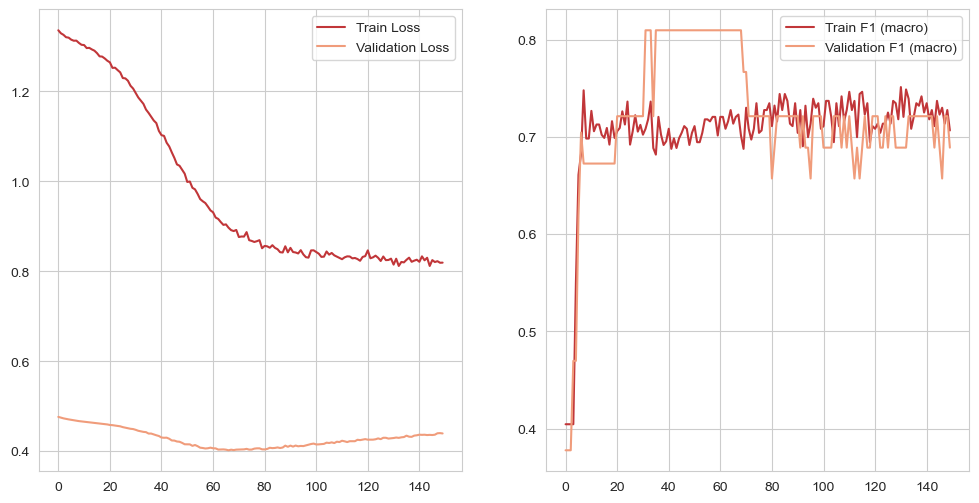

In [9]:
# ------------------- SETUP of experiment
# (1) USER DEFINED: the layers hyperparameters
# --- Global
activation = nn.LeakyReLU()
# --- Sage
aggregation = MaxPoolAggregation()
# --- Relevant for attention conv layer
global_softmax = True 


# (2) USER DEFINED: the model's architecture
num_features = len(X_train[0]['node_feat'][0])
architecture = [
    [GraphConv, {'in_features': num_features, 'out_features': 64, 'activation': activation}],
    [GraphConv, {'in_features': 64, 'out_features': 32, 'activation': activation}],
]

# (3) USER DEFINED: the model's hyperparameters
pooling = MaxPool()
dropout = 0.01
model = GNN(architecture, pooling, dropout=dropout).double()


# (4) USER DEFINED: training hyperparameters
lr = 1e-1
wd = 1e-5 # weight decay
epochs = 150
pos_weight = torch.Tensor([y_train.count(0)/y_train.count(1)])
criterion = BCEWithLogitsLoss(pos_weight=pos_weight)
# optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)
optimizer = SGD(model.parameters(), lr=lr, weight_decay=wd)

# ------------------- TRAINING given the setup
# (Optional) Log the setup of the experiment
if LOGEXP:
    # track hyperparameters and run metadata
    config = ( 
        {
            "experiment_group": "GraphConv [Node features]",
            "learning_rate": lr,
            "architecture": str(model),
            "conv_layers_type": str(architecture[0]),
            "dataset": "MUTAG",
            "epochs": epochs,
            "batch_size": batch_size,
            "optimizer": str(optimizer),
            "shuffle": shuffle,
            "pooling": str(pooling),
            "dropout": dropout,
            "weight_decay": wd,
            "pos_weight": pos_weight,
        }
    )
else:
    config = None

# Train the model
train_losses, train_f1s, val_losses, val_f1s = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs, config)

# Visualise the results
fig, axs = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

# Plot the losses
plot_losses_and_f1s(train_losses, train_f1s, axs, "Train")
plot_losses_and_f1s(val_losses, val_f1s, axs, "Validation")

#### Inspect closer the performance on the validation dataset

Val F1: 0.689
Val Accuracy: 0.714


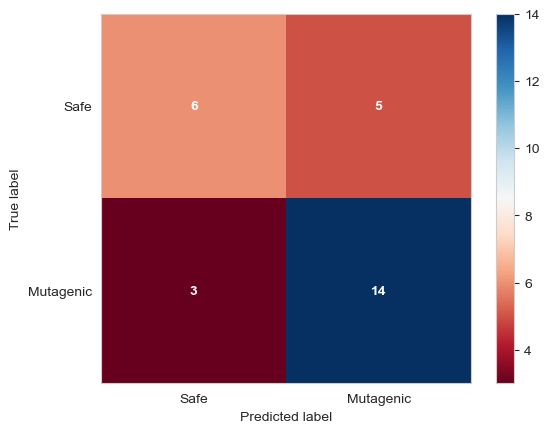

In [10]:
# Compute the test performance
_, val_f1, val_acc, val_true_pred = evaluate(model, val_loader, criterion)

# Print the test performance
print(f"Val F1: {val_f1:.3f}")
print(f"Val Accuracy: {val_acc:.3f}")

# Show the confusion matrix using sklearn
val_true, val_pred = val_true_pred

# Plot the confusion matrix
cm_val = confusion_matrix(val_true, val_pred)
display_val = ConfusionMatrixDisplay(cm_val, display_labels=["Safe", "Mutagenic"])
display_val = display_val.plot(cmap=sns.color_palette("RdBu", as_cmap=True));
for text in display_val.text_.ravel():
    text.set_color('white')
    text.set_weight('bold')

plt.grid(False)


#### Evaluate the test performance

Test F1: 0.739
Test Accuracy: 0.759


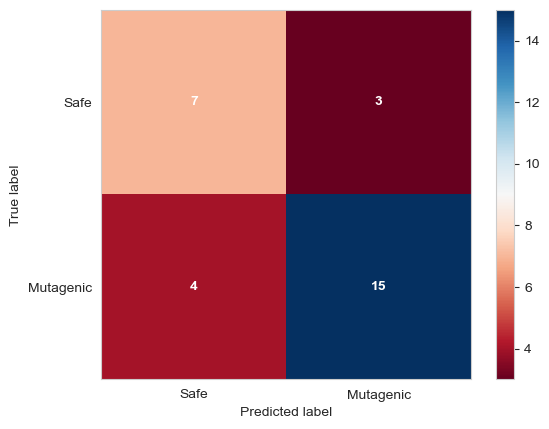

In [11]:
# Compute the test performance
_, test_f1, test_acc, test_true_pred = evaluate(model, test_loader, criterion)

# Print the test performance
print(f"Test F1: {test_f1:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Plot the confusion matrix
test_true, test_pred = test_true_pred

cm_test = confusion_matrix(test_true, test_pred)
display_test = ConfusionMatrixDisplay(cm_test, display_labels=["Safe", "Mutagenic"])
display_test = display_test.plot(cmap=sns.color_palette("RdBu", as_cmap=True));
for text in display_test.text_.ravel():
    text.set_color('white')
    text.set_weight('bold')

plt.grid(False)

---